In [1]:
%matplotlib inline
#mpld3.enable_notebook()
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
from astropy.io import ascii
import pytz
# OS interaction
import sys
import os
import glob
import seaborn as sns
sns.set_context("talk",font_scale=1.5)
sns.set_style('whitegrid')

# User config

In [2]:
# Paths to user files
data_dir = os.path.normpath(r'F:\Work\e\Data\Obs\Canada_Project_Sites\CSAS_data') # Where to store data on local computer

# Create paths

In [3]:
hourly_merged = os.path.join(data_dir,'merged','Hourly_Merged.nc')

In [4]:
QC_dir = os.path.join(data_dir,'QC')
# Make if does not exist
if not os.path.exists(QC_dir):
    os.makedirs(QC_dir)
netcdf_file_out = os.path.join(QC_dir, 'Hourly_QC.nc')

# QC merged data

In [5]:
ds_merged = xr.open_dataset(hourly_merged)

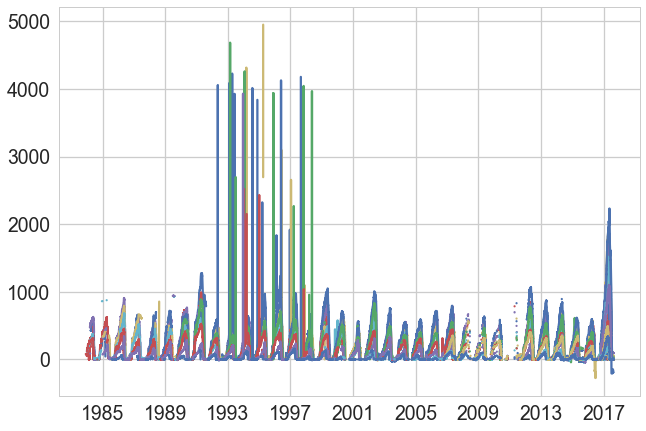

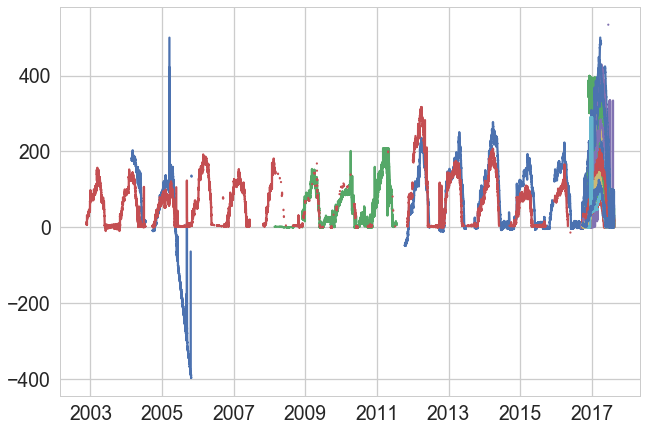

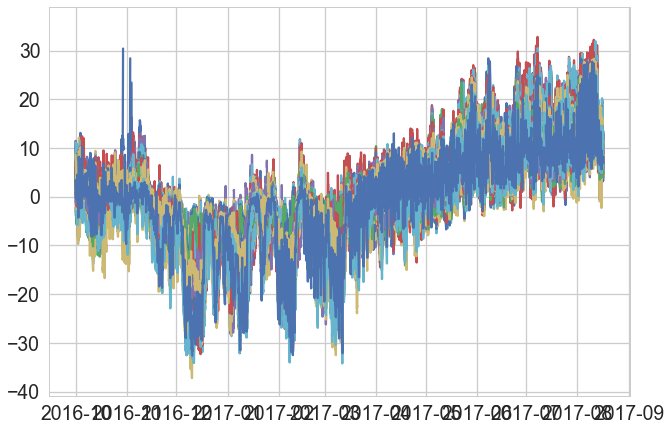

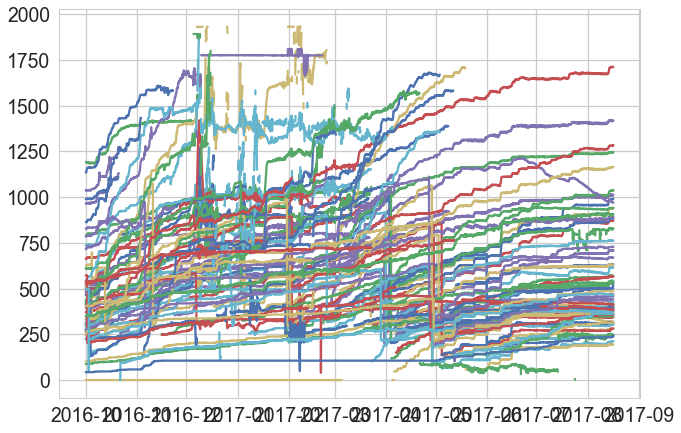

In [6]:
plt.figure()
plt.plot(ds_merged.Time_UTC,ds_merged.SWE.T.values);
plt.figure()
plt.plot(ds_merged.Time_UTC,ds_merged.Snowdepth.T.values);
plt.figure()
plt.plot(ds_merged.Time_UTC,ds_merged.AirTemperature.T.values);
plt.figure()
plt.plot(ds_merged.Time_UTC,ds_merged.Precipitation.T.values);

In [7]:
ds = ds_merged.copy() # Make copy to QC (allows comparison at end)

# Quality control data here

In [8]:
## Quality Control

## Max and min
# SWE
max_swe = 3000 # mm
min_swe = 0 # mm
ds['SWE'] = ds.SWE.where((ds.SWE<max_swe) &  (ds.SWE>min_swe))

# SD
max_sd = 550 # cm
min_sd = 0 # cm
ds['Snowdepth'] = ds.Snowdepth.where((ds.Snowdepth<max_sd) &                                                              
                                               (ds.Snowdepth>min_sd))

# Precip
max_p = 3000 # m
min_p = 0 # m
ds['Precipitation'] = ds.Precipitation.where((ds.Precipitation<max_p) &                                                              
                                               (ds.Precipitation>min_p))

# Tair
max_tar = 40 # C
min_tar = -50 # C
ds['AirTemperature'] = ds.AirTemperature.where((ds.AirTemperature<max_tar) & 
                                                        (ds.AirTemperature>min_tar))

C:\Users\new356\Anaconda3\lib\site-packages\xarray\core\variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive
C:\Users\new356\Anaconda3\lib\site-packages\xarray\core\variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


In [9]:
def remove_outliers_via_filter(x,threshold,window):
    if(sum(np.isnan(x.values))/len(x.values)>0.9): # Mostly nan, just return x, otherwise filter fails
        return x
    else: # Have some data, apply the median filter and remove differences greater than threshold
        # Apply median filter
        temp = x.to_series().rolling(window=window, center=True).median().fillna(method='bfill').fillna(method='ffill')
        # Take difference between filter and orig data
        difference = np.abs(x.to_series() - temp)
        # Find those data values that the diff was less than the user supplied threshold
        inlier_idx  = difference < threshold
        return x.where(inlier_idx)

In [10]:
## ROC - Use median filter to find values

# SD
SD_ROC_threshold = 50 # cm/hr
SD_ROC_window = 10 # dt (hrs)
ds['Snowdepth'] = ds.Snowdepth.groupby('staID').apply(lambda x: remove_outliers_via_filter(x,SD_ROC_threshold,SD_ROC_window))

# SWE
SWE_ROC_threshold = 50 # mm/hr
SWE_ROC_window = 10 # dt (hrs)
ds['SWE'] = ds.SWE.groupby('staID').apply(lambda x: remove_outliers_via_filter(x,SWE_ROC_threshold,SWE_ROC_window))

# Accumulated Precip (total)
P_ROC_threshold = 20 # mm/hr
P_ROC_window = 48 # dt (hrs)
ds['Precipitation'] = ds.Precipitation.groupby('staID').apply(lambda x: remove_outliers_via_filter(x,P_ROC_threshold,P_ROC_window))

# Air temperature
T_ROC_threshold = 10 # C/hr
T_ROC_window = 6 # dt (hrs)
ds['AirTemperature'] = ds.AirTemperature.groupby('staID').apply(lambda x: remove_outliers_via_filter(x,T_ROC_threshold,T_ROC_window))

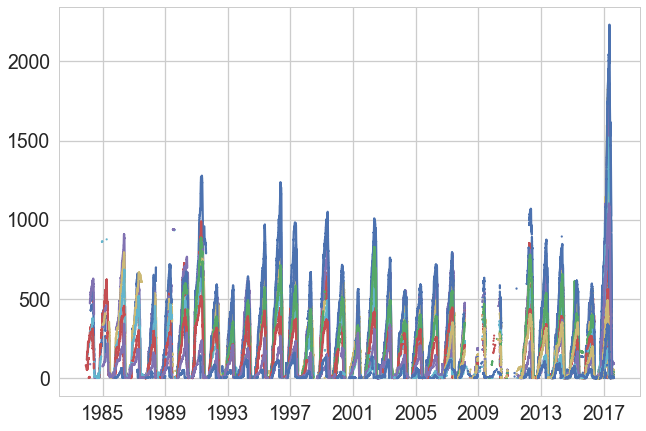

In [11]:
plt.plot(ds.Time_UTC,ds.SWE.T.values);

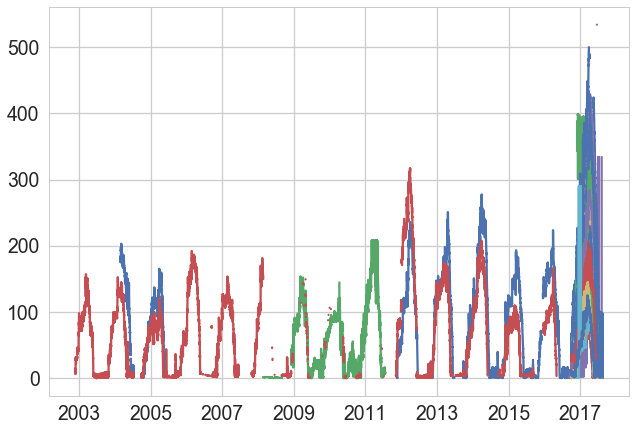

In [12]:
plt.plot(ds.Time_UTC,ds.Snowdepth.T.values);

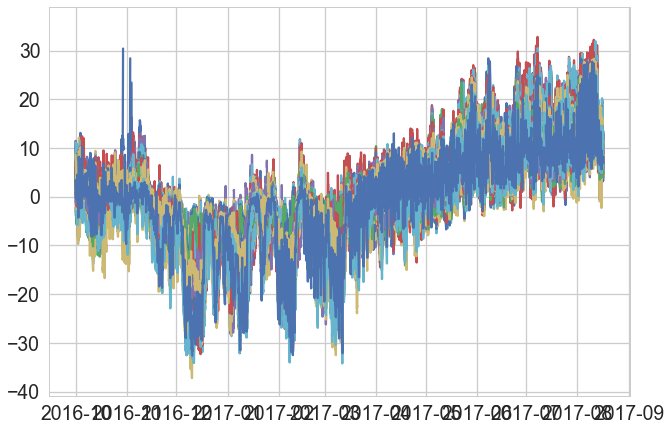

In [13]:
plt.plot(ds.Time_UTC,ds.AirTemperature.T.values);

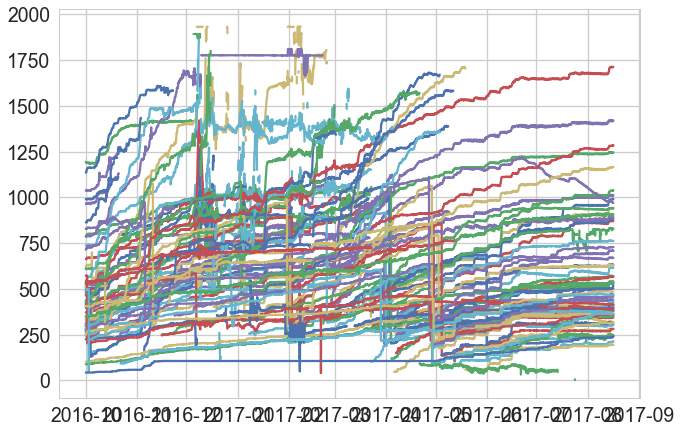

In [14]:
plt.plot(ds.Time_UTC,ds.Precipitation.T.values);

In [15]:
# Save as netcdf file
ds.to_netcdf(netcdf_file_out)